Duomenų rinkinio forma: (6984, 10)

Pirmieji 5 įrašai:
  nuts2_code  year  employment_rate  rd_expenditure_pct_gdp  \
0       AL01  2012              NaN                     NaN   
1       AL01  2013              NaN                     NaN   
2       AL01  2014              NaN                     NaN   
3       AL01  2015              NaN                     NaN   
4       AL01  2016              NaN                     NaN   

   unemployment_rate  tertiary_education_pct  youth_unemployment_rate  \
0                NaN                     NaN                      NaN   
1                NaN                     NaN                      NaN   
2                NaN                     NaN                      NaN   
3                NaN                     NaN                      NaN   
4                NaN                     NaN                      NaN   

   population_density  long_term_unemployment_share  female_employment_rate  
0                79.2                           N

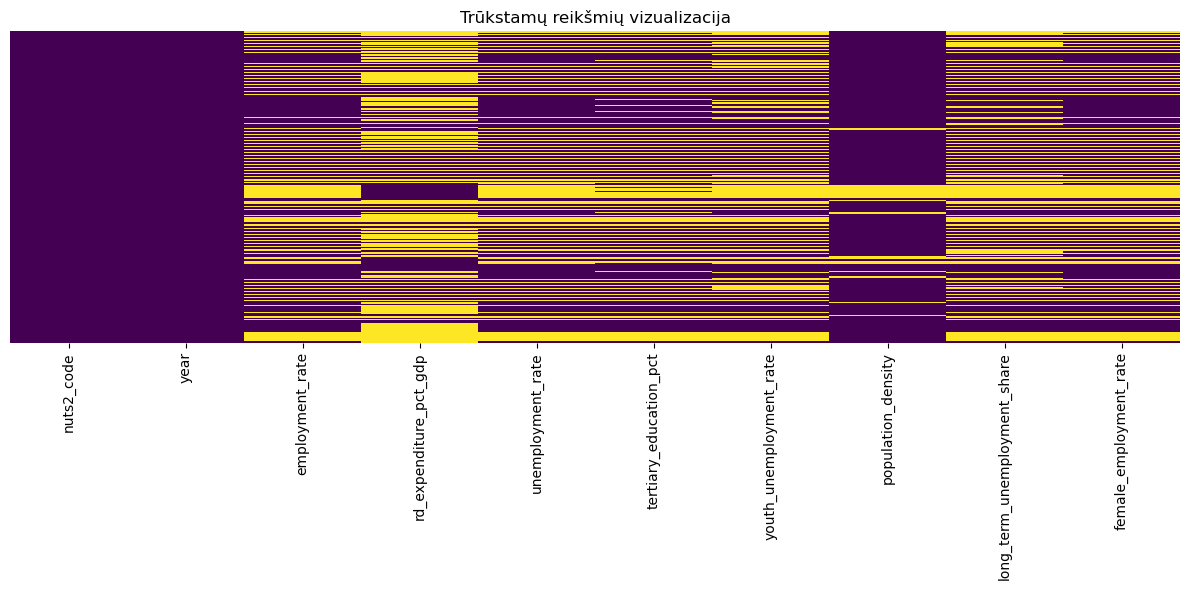

In [1]:
# Reikalingų bibliotekų importavimas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import time
import warnings
warnings.filterwarnings('ignore')


# Arba jei failas jau yra Colab aplinkoje:
df = pd.read_csv('http://mreri.us.lt/nuts2_economic_indicators_2025-03-20.csv')

# Duomenų rinkinio pirminė analizė
print("Duomenų rinkinio forma:", df.shape)
print("\nPirmieji 5 įrašai:")
print(df.head())

# Statistinė duomenų analizė
print("\nStatistinė informacija:")
print(df.describe())

# Trūkstamų reikšmių analizė
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100
missing_df = pd.DataFrame({
    'Trūkstamos reikšmės': missing_values,
    'Procentas (%)': missing_percentage
})
print("\nTrūkstamų reikšmių analizė:")
print(missing_df[missing_df['Trūkstamos reikšmės'] > 0])  # Rodo tik stulpelius su trūkstamomis reikšmėmis

# Patikriname unikalius NUTS2 kodus ir metus
print("\nUnikalūs NUTS2 kodai:", df['nuts2_code'].nunique())
print("Unikalūs metai:", sorted(df['year'].unique()))

# Vizualizuojame trūkstamas reikšmes
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cbar=False, yticklabels=False, cmap='viridis')
plt.title('Trūkstamų reikšmių vizualizacija')
plt.tight_layout()
plt.show()

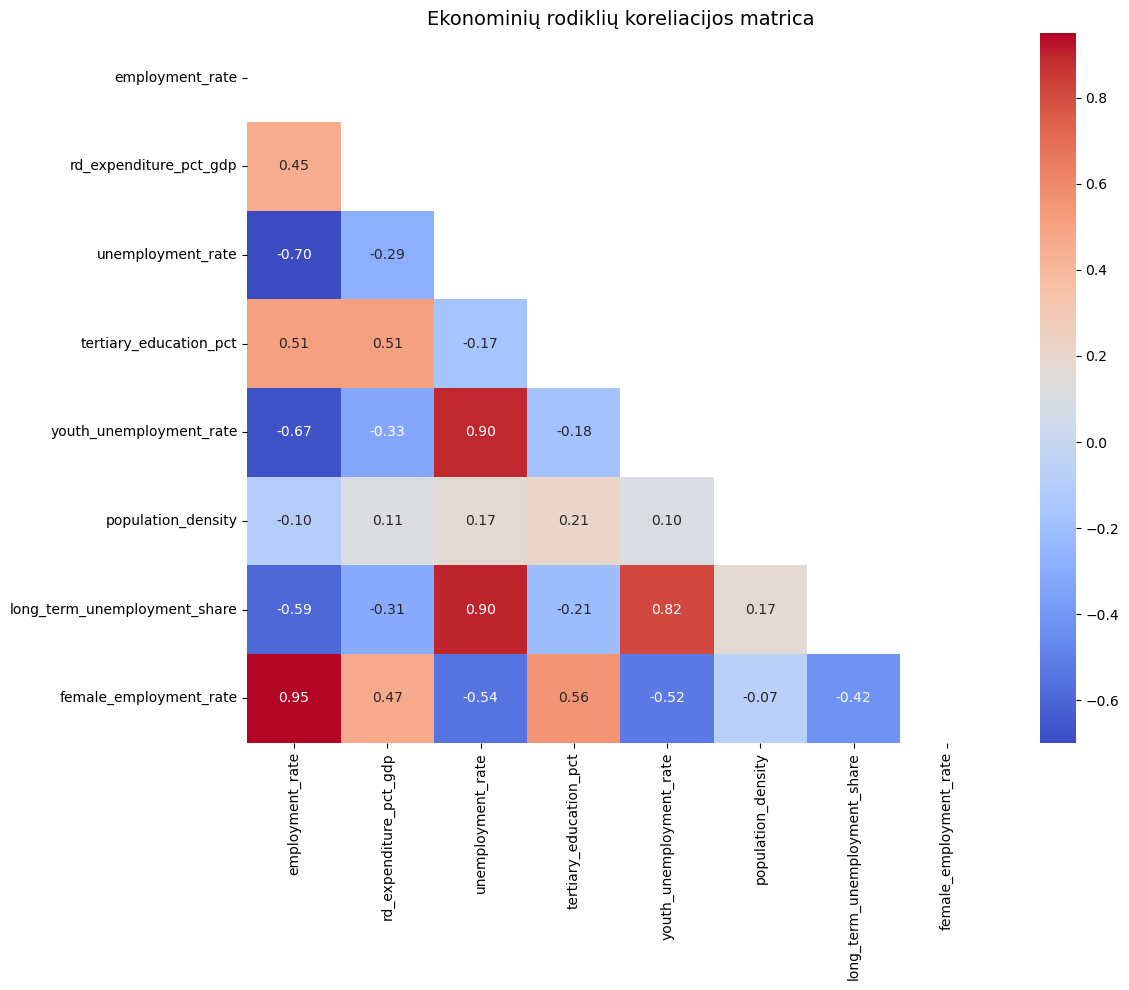

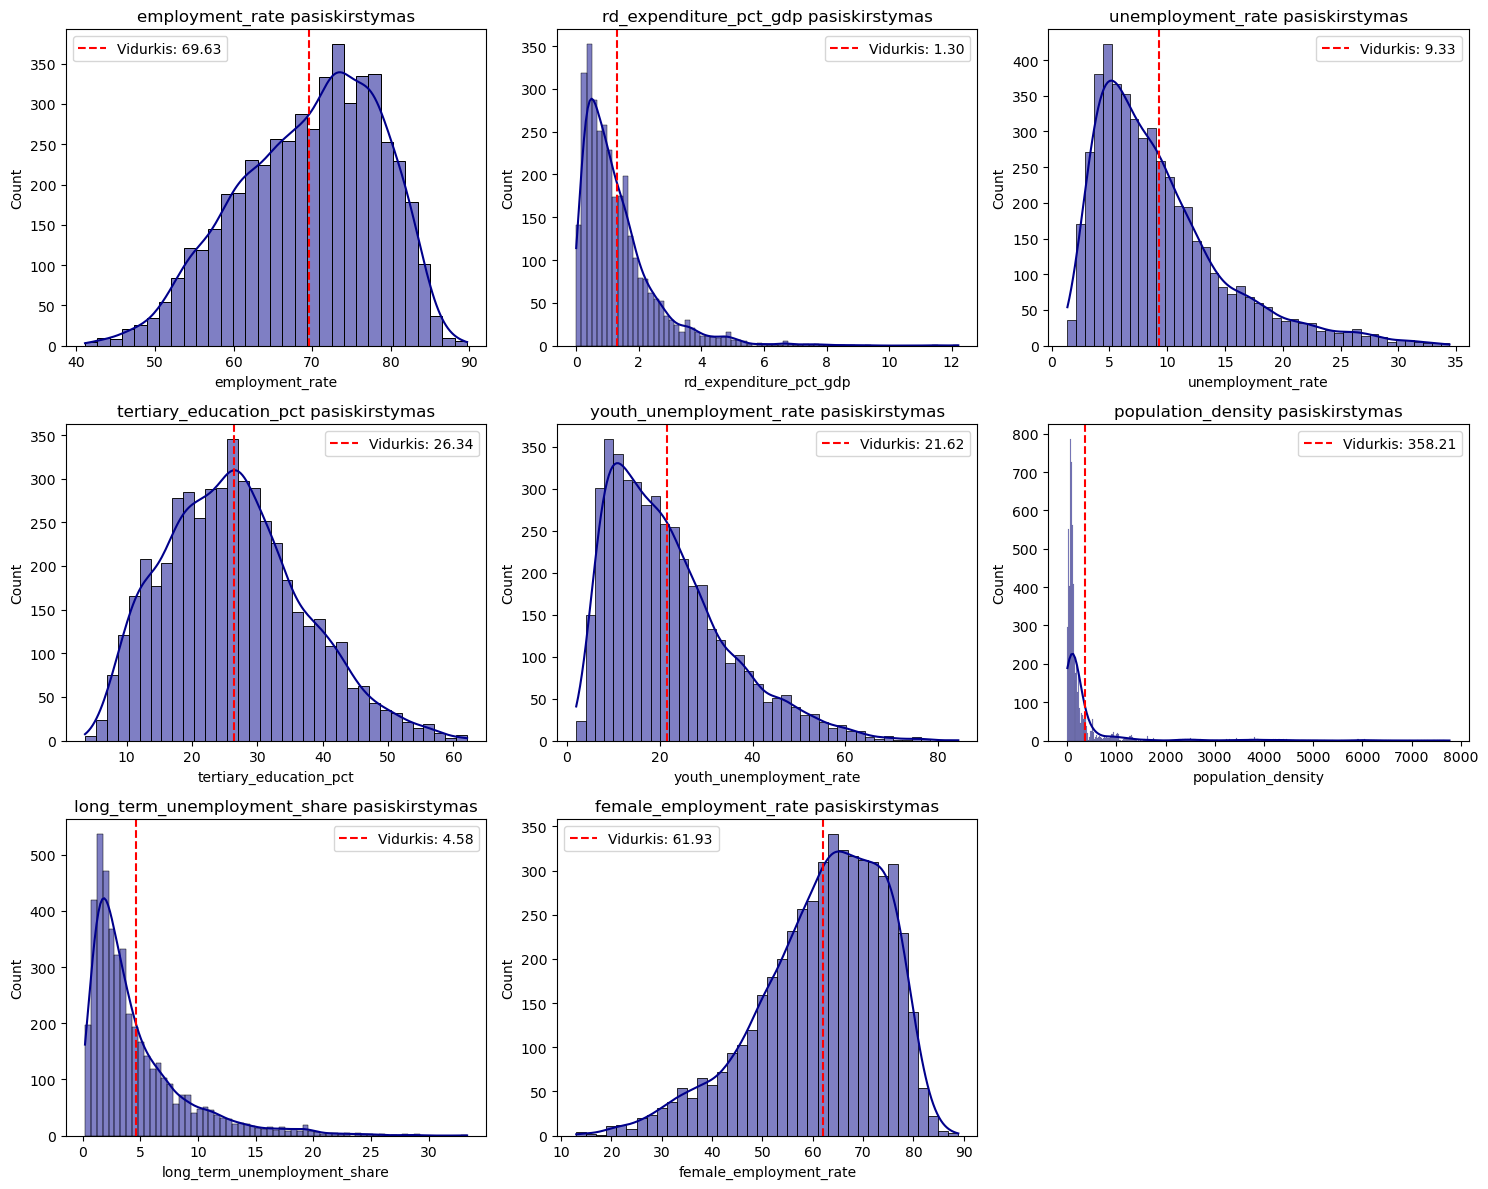

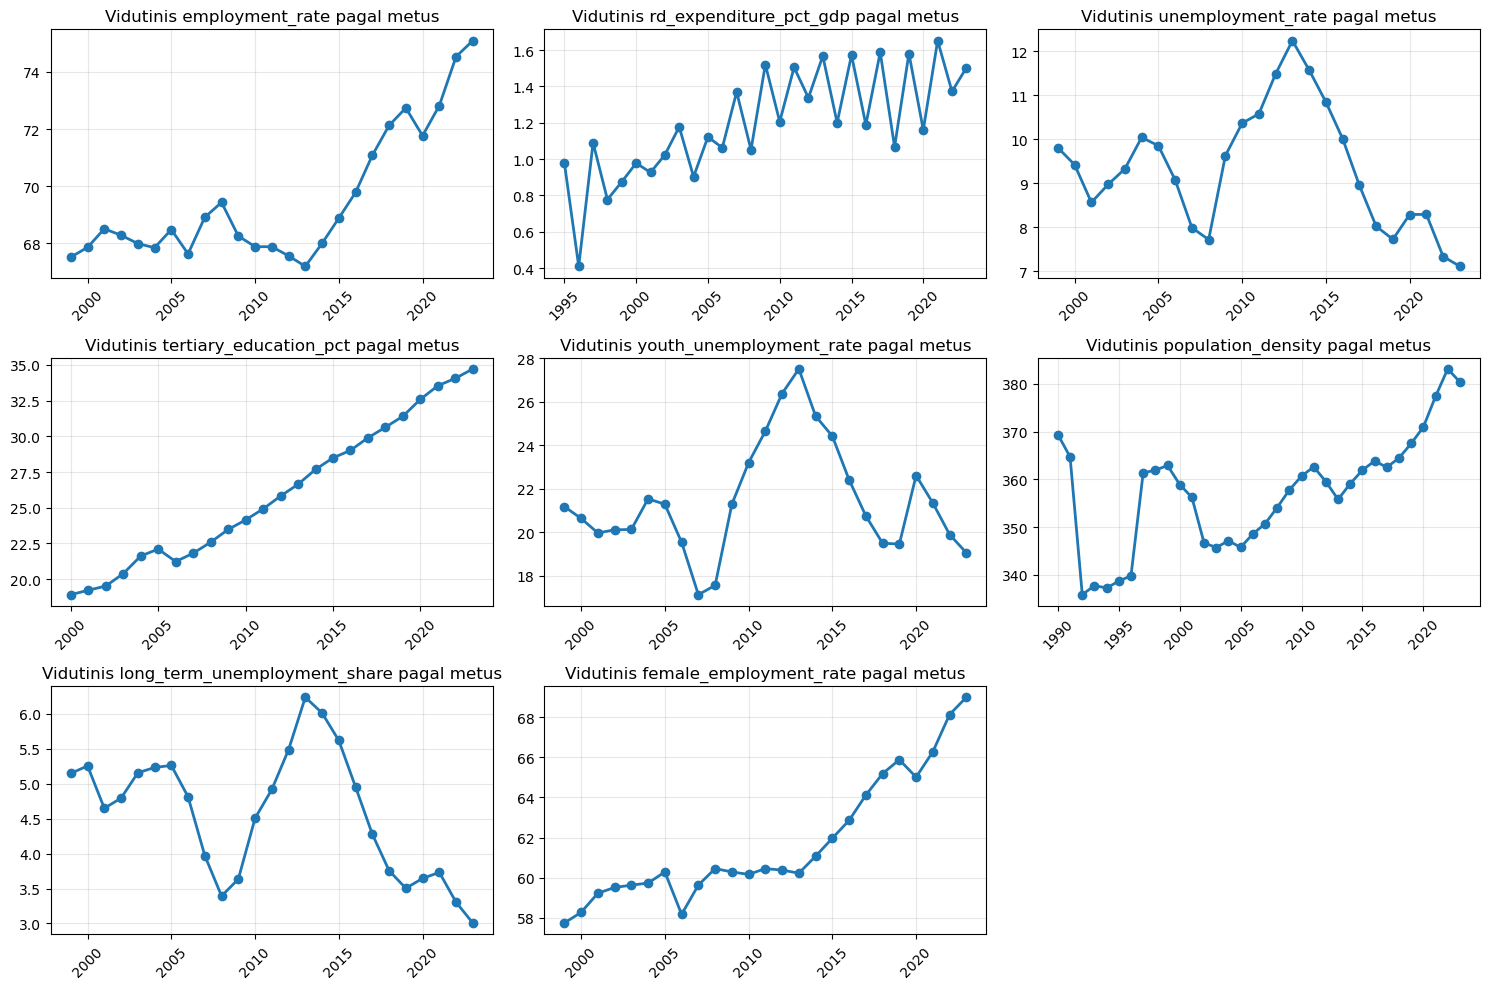

In [2]:
# Sukuriame koreliacijos matricą
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
economic_indicators = [col for col in numeric_cols if col not in ['nuts2_code', 'year']]

plt.figure(figsize=(12, 10))
correlation_matrix = df[economic_indicators].corr()
mask = np.triu(correlation_matrix)  # Maskuojame viršutinį trikampį (kad išvengtume dubliavimo)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', mask=mask)
plt.title('Ekonominių rodiklių koreliacijos matrica', fontsize=14)
plt.tight_layout()
plt.show()

# Duomenų pasiskirstymo analizė
plt.figure(figsize=(15, 12))
for i, col in enumerate(economic_indicators):
    plt.subplot(3, 3, i+1)
    if df[col].notna().sum() > 0:
        sns.histplot(df[col].dropna(), kde=True, color='darkblue')
        plt.title(f'{col} pasiskirstymas', fontsize=12)
        plt.axvline(df[col].dropna().mean(), color='red', linestyle='--',
                    label=f'Vidurkis: {df[col].dropna().mean():.2f}')
        plt.legend()
plt.tight_layout()
plt.show()

# Išsamesnė analizė pagal laiko periodą
plt.figure(figsize=(15, 10))
for i, col in enumerate(economic_indicators):
    plt.subplot(3, 3, i+1)
    if df[col].notna().sum() > 0:
        yearly_data = df.groupby('year')[col].mean()
        plt.plot(yearly_data.index, yearly_data.values, 'o-', linewidth=2)
        plt.title(f'Vidutinis {col} pagal metus', fontsize=12)
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [3]:
# Sukuriame funkciją, kuri sukurs sintetinius testus RF imputavimo efektyvumui įvertinti
def create_synthetic_test_data(df, target_column, missing_percentage=20):
    """
    Sukuria sintetinius testus RF imputavimo efektyvumui įvertinti

    Parametrai:
    -----------
    df : DataFrame
        Duomenų rinkinys
    target_column : str
        Stulpelio pavadinimas, kuriam bus sukurti sintetiniai testai
    missing_percentage : int
        Procentas duomenų, kurie bus pašalinti testavimui

    Grąžina:
    --------
    df_train : DataFrame
        Duomenų rinkinys su pašalintomis reikšmėmis
    df_test : DataFrame
        Duomenų rinkinys su originaliais duomenimis testavimui
    """
    # Kopijuojame duomenų rinkinį
    df_copy = df.copy()

    # Atfiltruojame duomenis, kuriuose tikslinė reikšmė nėra tuščia
    df_with_target = df_copy[df_copy[target_column].notna()]

    if len(df_with_target) == 0:
        print(f"Įspėjimas: stulpelyje {target_column} nėra duomenų imputavimo testavimui.")
        return df_copy, pd.DataFrame()

    # Dalijame duomenis į mokymo ir testavimo rinkinius
    train_indices, test_indices = train_test_split(
        df_with_target.index,
        test_size=missing_percentage/100,
        random_state=42
    )

    # Sukuriame mokymo duomenų rinkinį su pašalintomis reikšmėmis
    df_train = df_copy.copy()
    df_train.loc[test_indices, target_column] = np.nan

    # Sukuriame testavimo duomenų rinkinį
    df_test = df_copy.loc[test_indices, :].copy()

    return df_train, df_test

# Pasiruošiame duomenų rinkinį RF modelio metrikų įvertinimui
def prepare_data_for_all_indicators(df, indicators, missing_percentage=20):
    """
    Paruošia duomenų rinkinius visų rodiklių RF imputavimo efektyvumui įvertinti

    Parametrai:
    -----------
    df : DataFrame
        Duomenų rinkinys
    indicators : list
        Rodiklių sąrašas
    missing_percentage : int
        Procentas duomenų, kurie bus pašalinti testavimui

    Grąžina:
    --------
    train_data : dict
        Žodynas su mokymo duomenų rinkiniais kiekvienam rodikliui
    test_data : dict
        Žodynas su testavimo duomenų rinkiniais kiekvienam rodikliui
    """
    train_data = {}
    test_data = {}

    for indicator in indicators:
        train_df, test_df = create_synthetic_test_data(df, indicator, missing_percentage)
        # Išsaugome tik jei yra duomenų testavimui
        if not test_df.empty:
            train_data[indicator] = train_df
            test_data[indicator] = test_df

    return train_data, test_data

# Paruošiame duomenis
train_data_dict, test_data_dict = prepare_data_for_all_indicators(df, economic_indicators, missing_percentage=20)

print(f"Paruošti duomenų rinkiniai {len(train_data_dict)} rodikliams:")
for indicator in train_data_dict:
    test_size = len(test_data_dict[indicator])
    print(f"  - {indicator}: {test_size} testavimo įrašai")

Paruošti duomenų rinkiniai 8 rodikliams:
  - employment_rate: 1004 testavimo įrašai
  - rd_expenditure_pct_gdp: 646 testavimo įrašai
  - unemployment_rate: 992 testavimo įrašai
  - tertiary_education_pct: 982 testavimo įrašai
  - youth_unemployment_rate: 883 testavimo įrašai
  - population_density: 1257 testavimo įrašai
  - long_term_unemployment_share: 907 testavimo įrašai
  - female_employment_rate: 1004 testavimo įrašai


In [5]:
# Funkcija baziniam RF modeliui
def train_basic_rf_model(df_train, target_column, feature_cols=None):
    """
    Apmoko bazinį RF modelį

    Parametrai:
    -----------
    df_train : DataFrame
        Mokymo duomenų rinkinys
    target_column : str
        Stulpelio pavadinimas, kuriam bus sukurtas modelis
    feature_cols : list, optional
        Požymių stulpeliai. Jei nepateikti, naudojami visi skaitiniai stulpeliai

    Grąžina:
    --------
    model : RandomForestRegressor
        Apmokytas RF modelis
    X_train : DataFrame
        Požymių duomenys mokymuisi
    """
    df_not_missing = df_train[df_train[target_column].notna()]

    # Nustatome požymių stulpelius
    if feature_cols is None:
        feature_cols = [col for col in df_train.select_dtypes(include=['float64', 'int64']).columns
                       if col != target_column and col not in ['nuts2_code', 'year']]

    # Užpildome trūkstamas reikšmes požymių stulpeliuose
    X_train = df_not_missing[feature_cols].copy()

    for col in feature_cols:
        if X_train[col].isnull().any():
            X_train[col] = X_train[col].fillna(X_train[col].mean())

    y_train = df_not_missing[target_column]

    # Apmokome bazinį RF modelį
    rf_model = RandomForestRegressor(
        n_estimators=100,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        random_state=42
    )

    rf_model.fit(X_train, y_train)

    return rf_model, X_train

# Funkcija prognozėms ir metrikoms
def evaluate_rf_model(model, df_train, df_test, target_column, feature_cols=None):
    """
    Vertina RF modelio efektyvumą

    Parametrai:
    -----------
    model : RandomForestRegressor
        Apmokytas RF modelis
    df_train : DataFrame
        Mokymo duomenų rinkinys
    df_test : DataFrame
        Testavimo duomenų rinkinys
    target_column : str
        Stulpelio pavadinimas, kuriam buvo sukurtas modelis
    feature_cols : list, optional
        Požymių stulpeliai. Jei nepateikti, naudojami visi skaitiniai stulpeliai

    Grąžina:
    --------
    metrics : dict
        Modelio metrikos
    y_pred : array
        Prognozuotos reikšmės
    """
    # Nustatome požymių stulpelius
    if feature_cols is None:
        feature_cols = [col for col in df_train.select_dtypes(include=['float64', 'int64']).columns
                       if col != target_column and col not in ['nuts2_code', 'year']]

    # Paruošiame testavimo duomenis
    X_test = df_test[feature_cols].copy()

    for col in feature_cols:
        if X_test[col].isnull().any():
            mean_val = df_train[df_train[target_column].notna()][col].mean()
            X_test[col] = X_test[col].fillna(mean_val)

    y_true = df_test[target_column]

    # Prognozuojame
    y_pred = model.predict(X_test)

    # Skaičiuojame metrikas
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    # Skaičiuojame santykinę procentinę paklaidą
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    metrics = {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2,
        'MAPE (%)': mape
    }

    return metrics, y_pred

# Vykdome bazinio RF modelio testavimą visiems rodikliams
baseline_metrics = {}
baseline_predictions = {}

print("Bazinio RF modelio metrikos:")
print("-" * 80)
print(f"{'Rodiklis':<25} {'MSE':<12} {'RMSE':<12} {'MAE':<12} {'R²':<12} {'MAPE (%)':<12}")
print("-" * 80)

for indicator in train_data_dict:
    # Apmokome modelį
    model, X_train = train_basic_rf_model(train_data_dict[indicator], indicator)

    # Įvertiname modelį
    metrics, predictions = evaluate_rf_model(model, train_data_dict[indicator], test_data_dict[indicator], indicator)

    # Išsaugome metrikas ir prognozes
    baseline_metrics[indicator] = metrics
    baseline_predictions[indicator] = predictions

    # Spausdiname rezultatus
    print(f"{indicator:<25} {metrics['MSE']:<12.4f} {metrics['RMSE']:<12.4f} {metrics['MAE']:<12.4f} {metrics['R²']:<12.4f} {metrics['MAPE (%)']:<12.4f}")

print("-" * 80)

Bazinio RF modelio metrikos:
--------------------------------------------------------------------------------
Rodiklis                  MSE          RMSE         MAE          R²           MAPE (%)    
--------------------------------------------------------------------------------
employment_rate           1.9420       1.3936       1.0516       0.9739       1.5586      
rd_expenditure_pct_gdp    0.4557       0.6751       0.4096       0.7180       inf         
unemployment_rate         2.2041       1.4846       1.0418       0.9344       13.2975     
tertiary_education_pct    23.9705      4.8960       3.5438       0.7819       15.0099     
youth_unemployment_rate   20.1910      4.4934       3.1664       0.8828       17.6417     
population_density        369181.5051  607.6031     273.5064     0.4586       323.1901    
long_term_unemployment_share 1.8774       1.3702       0.8884       0.8862       26.3958     
female_employment_rate    4.9056       2.2148       1.5780       0.9668       